In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.models import Model
from PIL import Image
import IPython.display as display

In [2]:
def load_image(image_path, max_dim=400):
    img = Image.open(image_path)
    img = img.convert("RGB")
    img.thumbnail([max_dim, max_dim])
    img = np.array(img, dtype=np.uint8)
    img = np.expand_dims(img, axis=0)
    return img

In [3]:
def deprocess_inception_image(img):
    img = 255*(img+1.0)/2.0
    return np.array(img, np.uint8)

In [4]:
def array_to_img(array, deprocessing=False):
    if deprocessing:
        array = deprocess_inception_image(array)

    if np.ndim(array)>3:
        assert array.shape[0]==1
        array=array[0]
        
    return Image.fromarray(array)

In [5]:
def show_image(img):
    image = array_to_img(img)
    display.display(image)

In [6]:
def deep_dream_model(model, layer_names):
    model.trainable = False
    outputs=[model.get_layer(name).output for name in layer_names]
    new_model = Model(inputs=model.input, outputs=outputs)
    return new_model

In [7]:
def get_loss(activations):
    loss = []
    for activation in activations:
        loss.append(tf.math.reduce_mean(activation))
    return tf.reduce_sum(loss)

In [8]:
def model_output(model, inputs):
    return model(inputs)

In [9]:
def get_loss_and_gradient(model, inputs, total_variation_weight=0):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        activations=model_output(model,inputs)
        loss = get_loss(activations)
        loss = loss + total_variation_weight*tf.image.total_variation(inputs)
    grads = tape.gradient(loss,inputs)
    grads /= tf.math.reduce_std(grads) + 1e-8 
    return loss, grads

In [10]:
def run_gradient_ascent(model, inputs, epochs=1, steps_per_epoch=1, weight=0.05, total_variation_weight=0):
    img = tf.convert_to_tensor(inputs)
    for i in range(epochs):
        for _ in range(steps_per_epoch):
            _, grads = get_loss_and_gradient(model,img,total_variation_weight)
            img = img + grads*weight
            img = tf.clip_by_value(img, -1.0, 1.0)
            
    return img.numpy()

In [11]:
input_img_path = 'Images/lake.jpg'

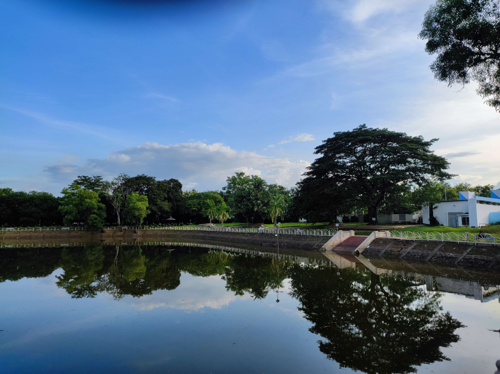

In [12]:
input_image = load_image(input_img_path, max_dim=500)
# print(input_image.shape)
show_image(input_image)

In [13]:
preprocessed_image = inception_v3.preprocess_input(input_image)
inception = inception_v3.InceptionV3(weights="imagenet", include_top=False)
layers_contributions=['mixed4', 'mixed5', 'mixed9', 'mixed10']
dream_model = deep_dream_model(inception, layers_contributions)
deep_outputs = dream_model(preprocessed_image)

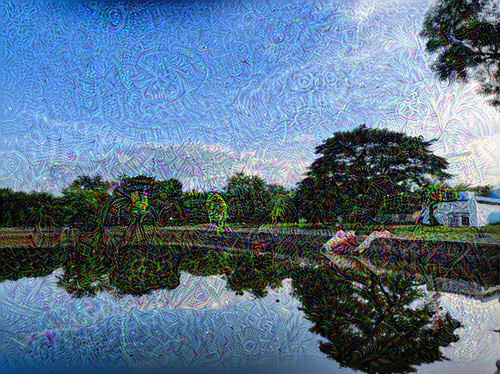

In [14]:
image_array = run_gradient_ascent(dream_model, preprocessed_image, epochs=2, steps_per_epoch=50, weight=0.02)

show_image(deprocess_inception_image(image_array))